In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm, uniform

In [2]:
# Significance level
ALPHA = 0.05

---

In [3]:
def PlotSimpleRegression(data, x, y, model, alpha, ax, fit_to_obs=True, x_vect=None):

    if fit_to_obs:
        data = data.copy()
        data = data.sort_values(x).reset_index(drop=True)
        x_plot = data[x]

        pred_table = model.get_prediction(data[x]).summary_frame(alpha=alpha)
    else:
        _ = pd.DataFrame({"X": x_vect})
        x_plot = x_vect
        pred_table = model.get_prediction(_["X"]).summary_frame(alpha=alpha)

    # Scatterplot of the observations
    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        ax=ax,
        label="Observations"
    )

    # Plot predicted mean
    ax.plot(
        x_plot,
        pred_table["mean"],
        color="k",
        label="Prediction"
    )

    # Plot prediction interval
    ax.fill_between(
        x_plot,
        pred_table["obs_ci_lower"],
        pred_table["obs_ci_upper"],
        color="rebeccapurple",
        alpha=0.5,
        label="Prediction interval"
    )

    # Plot confidence interval
    ax.fill_between(
        x_plot,
        pred_table["mean_ci_lower"],
        pred_table["mean_ci_upper"],
        color="pink",
        alpha=0.5,
        label="Confidence interval"
    )

    ax.legend(frameon=False)
    ax.spines[['right', 'top']].set_visible(False)

    return ax

In [4]:
def PlotCompareYHatY(data, y, model, alpha, ax):

    pred_table = model.get_prediction().summary_frame(alpha=alpha)

    ax.scatter(
        data[y],
        pred_table["mean"],
        color="k"
    )

    ax.errorbar(
        data[y],
        pred_table["mean"],
        yerr=pred_table["obs_ci_upper"] - pred_table["mean"],
        fmt="o",
        color="k"
    )

    ax.plot(
        [data[y].min(), data[y].max()]
        , [data[y].min(), data[y].max()]
        , color='r'
        , linestyle='--'
    )

    ax.set_xlabel(r"$Y$")
    ax.set_ylabel(r"$\hat{Y}$")
    ax.spines[['right', 'top']].set_visible(False)

    return ax

---

## Example 1

Simulate observations from the model:

$$Y= \beta_0 + \beta_1 X + \varepsilon,\quad \varepsilon\sim\textsf{Normal}(0,\sigma^2)$$

In [5]:
Beta0, Beta1 = 10, 2
Sigma = 0.5
N = 20

np.random.seed(111)
XSample = uniform.rvs(0, 1, size=N)
Epsilon = norm.rvs(0, Sigma, size=N)

YSample = Beta0 + Beta1 * XSample + Epsilon

Dat = pd.DataFrame({"Y": YSample, "X":XSample})

<Axes: xlabel='X', ylabel='Y'>

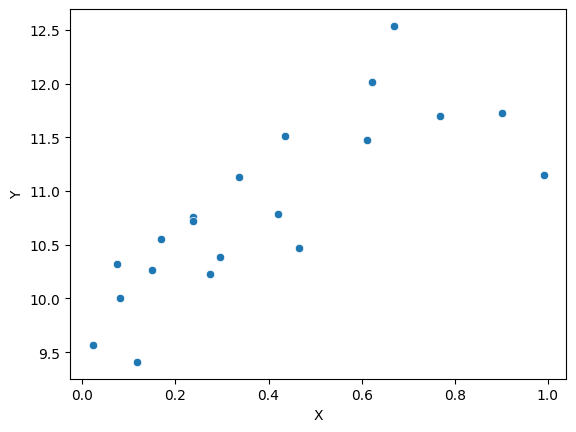

In [6]:
sns.scatterplot(data=Dat, x="X", y="Y")

## Regression using sm.OLS

In this case, we need to add a constant to the x variable, otherwise it won't fit an intercept.

In [7]:
RegModel = sm.OLS(YSample, sm.add_constant(Dat["X"]))
RegModel = RegModel.fit()

In [8]:
RegModel.summary2(alpha=ALPHA)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.597   
Dependent Variable: y                AIC:                32.2930 
Date:               2025-05-19 16:13 BIC:                34.2844 
No. Observations:   20               Log-Likelihood:     -14.146 
Df Model:           1                F-statistic:        29.10   
Df Residuals:       18               Prob (F-statistic): 3.99e-05
R-squared:          0.618            Scale:              0.26771 
-------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|    [0.025    0.975]
-------------------------------------------------------------------
const       9.9482     0.2011   49.4646   0.0000   9.5257   10.3708
X           2.2512     0.4173    5.3944   0.0000   1.3744    3.1279
-----------------------------------------------------------------
Omnibus:               0.290        Durbin-Watson:          1.835
Prob(Omnibus):         0.865        Jarque-Bera (JB):       0.003
Skew:                  -0.008       Prob(JB):               0.999
Kurtosis:              2.944        Condition No.:          4    
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

Get confidence and prediction intervals

## Regression using smf.ols

In this case, it adds a constant to the x variable automatically.

In [9]:
RegModel = smf.ols(data=Dat, formula="Y ~ X")
RegModel = RegModel.fit()

In [10]:
RegModel.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.597   
Dependent Variable: Y                AIC:                32.2930 
Date:               2025-05-19 16:13 BIC:                34.2844 
No. Observations:   20               Log-Likelihood:     -14.146 
Df Model:           1                F-statistic:        29.10   
Df Residuals:       18               Prob (F-statistic): 3.99e-05
R-squared:          0.618            Scale:              0.26771 
-------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|    [0.025    0.975]
-------------------------------------------------------------------
Intercept   9.9482     0.2011   49.4646   0.0000   9.5257   10.3708
X           2.2512     0.4173    5.3944   0.0000   1.3744    3.1279
-----------------------------------------------------------------
Omnibus:               0.290        Durbin-Watson:          1.835
Prob(Omnibus):         0.865        Jarque-Bera (JB):       0.003
Skew:                  -0.008       Prob(JB):               0.999
Kurtosis:              2.944        Condition No.:          4    
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

<Axes: xlabel='X', ylabel='Y'>

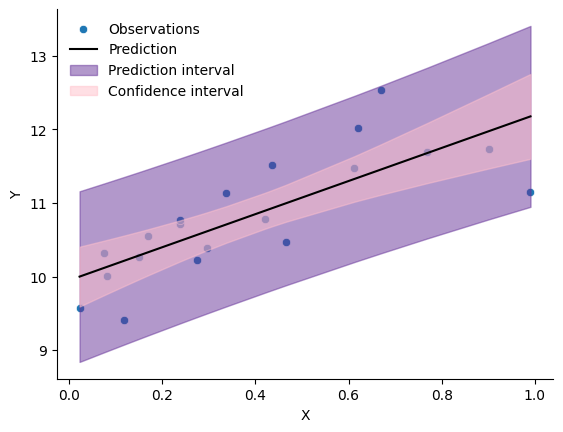

In [11]:
_, ax = plt.subplots(1, 1)
PlotSimpleRegression(Dat, "X", "Y", RegModel, ALPHA, ax)

<Axes: xlabel='$Y$', ylabel='$\\hat{Y}$'>

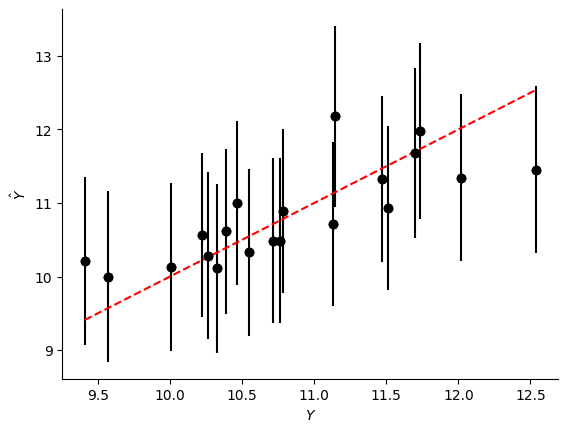

In [12]:
_, ax = plt.subplots(1, 1)
PlotCompareYHatY(Dat, "Y", RegModel, ALPHA, ax)

---

## Example 2

Simulate observations from the model:

$$Y= \beta_0 + \beta_1 X + \beta_2\sin(X) + \beta_3 (X-5)^2 + \varepsilon,\quad \varepsilon\sim\textsf{Normal}(0,\sigma^2)$$

In [13]:
Beta0, Beta1, Beta2, Beta3 = 5, 0.5, 0.5, -0.02
Sigma = 0.5
N = 50

np.random.seed(111)
XSample = uniform.rvs(0, 20, size=N)

Epsilon = norm.rvs(0, Sigma, size=N)

YSample = Beta0 + Beta1 * XSample + Beta2 * np.sin(XSample) + Beta3 * (XSample-5)**2 + Epsilon

Dat = pd.DataFrame({"Y": YSample, "X":XSample})

<Axes: xlabel='X', ylabel='Y'>

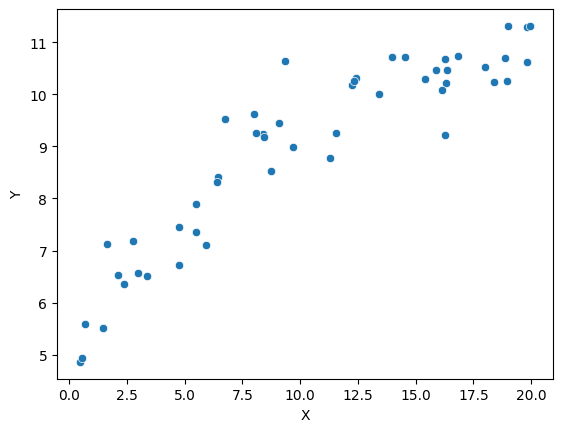

In [14]:
sns.scatterplot(data=Dat, x="X", y="Y")

In [15]:
RegModel = smf.ols(data=Dat, formula="Y ~ X + np.sin(X) + I((X-5)**2)")
RegModel = RegModel.fit()

In [16]:
RegModel.summary2(alpha=ALPHA)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.931   
Dependent Variable: Y                AIC:                71.8009 
Date:               2025-05-19 16:13 BIC:                79.4490 
No. Observations:   50               Log-Likelihood:     -31.900 
Df Model:           3                F-statistic:        222.1   
Df Residuals:       46               Prob (F-statistic): 2.28e-27
R-squared:          0.935            Scale:              0.22798 
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          5.2157   0.1731 30.1388 0.0000  4.8674  5.5641
X                  0.4724   0.0266 17.7575 0.0000  0.4188  0.5259
np.sin(X)          0.4776   0.1105  4.3237 0.0001  0.2553  0.7000
I((X - 5) ** 2)   -0.0182   0.0022 -8.2422 0.0000 -0.0227 -0.0138
-----------------------------------------------------------------
Omnibus:              2.119        Durbin-Watson:           1.794
Prob(Omnibus):        0.347        Jarque-Bera (JB):        1.229
Skew:                 0.287        Prob(JB):                0.541
Kurtosis:             3.510        Condition No.:           264  
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

Get confidence and prediction intervals

<Axes: xlabel='X', ylabel='Y'>

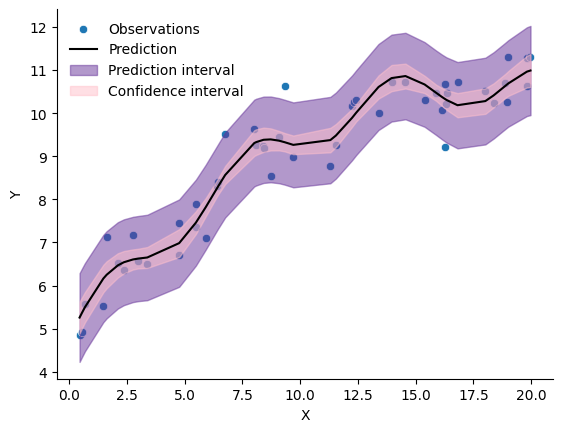

In [17]:
_, ax = plt.subplots(1, 1)
PlotSimpleRegression(Dat, "X", "Y", RegModel, ALPHA, ax)

<Axes: xlabel='X', ylabel='Y'>

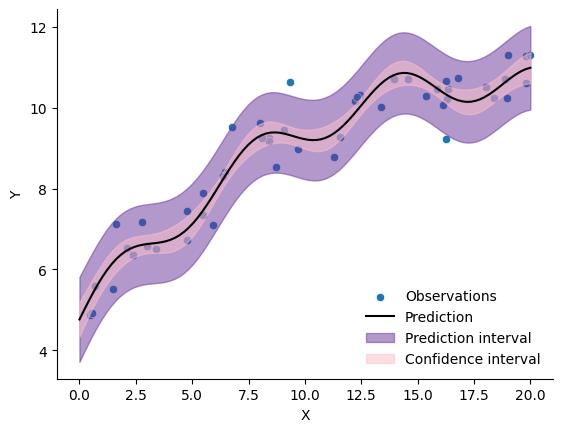

In [18]:
_, ax = plt.subplots(1, 1)
PlotSimpleRegression(Dat, "X", "Y", RegModel, ALPHA, ax, fit_to_obs=False, x_vect=np.linspace(0,20,100))

<Axes: xlabel='$Y$', ylabel='$\\hat{Y}$'>

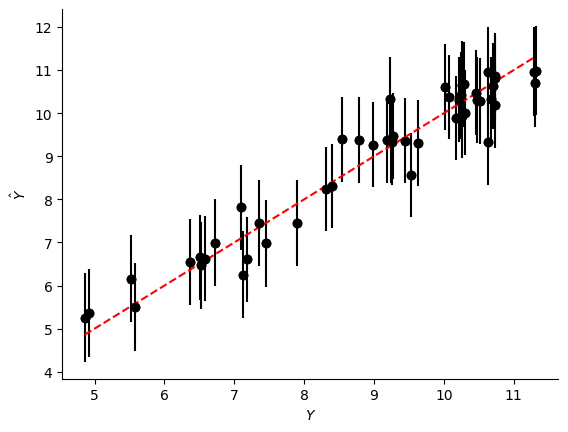

In [19]:
_, ax = plt.subplots(1, 1)
PlotCompareYHatY(Dat, "Y", RegModel, ALPHA, ax)